In [1]:
import numpy as np
import torch
import torchvision
from torchvision.transforms import v2 as transforms

from aivolved.dataset import get_img_dataset_normalisation

DATA_PATH = "data/soap/soap-80-20-20/"

train_dataset = torchvision.datasets.ImageFolder(
    DATA_PATH + "train",
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
    ])
)

mean, stdev = get_img_dataset_normalisation(train_dataset)

In [2]:
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomChannelPermutation(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, stdev)
])

train_dataset = torchvision.datasets.ImageFolder(DATA_PATH + "train", transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=256, num_workers=8, pin_memory=True, persistent_workers=True)
train_dataset

Dataset ImageFolder
    Number of datapoints: 757
    Root location: data/soap/soap-80-20-20/train
    StandardTransform
Transform: Compose(
                 Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[np.float64(0.24192692526564785), np.float64(0.29593605368584025), np.float64(0.3941905367042788)], std=[np.float64(0.18127346730200888), np.float64(0.1826646471862998), np.float64(0.21710274904106977)], inplace=False)
           )

In [3]:
from aivolved.device import get_device

device = get_device()

resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
resnet = resnet.to(device)
resnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [4]:
from tqdm.notebook import tqdm

preds = []
labels = []
with torch.no_grad():
    for epoch in tqdm(range(10)):
        for x, y in train_dataloader:
            x = x.to(device)
            preds.append(resnet(x))
            labels.append(y)
        
preds = torch.concat(preds).squeeze().cpu().numpy()
labels = torch.concat(labels).squeeze().numpy()

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
len(labels) / 13

582.3076923076923

In [7]:
import matplotlib.pyplot as plt


def plot(p, c=None, **kwargs):
    plt.figure()
    p = p.T
    
    if len(p) == 2:
        plt.scatter(*p[:2], c=c, **kwargs)
    elif len(p) == 3:
        a = plt.axes(projection="3d")
        a.scatter3D(*p, c=c, **kwargs)
    else:
        a = plt.axes(projection="3d")
        a.scatter3D(*p[:3], s=p[3] ** 2, c=c, **kwargs)
    
    return a

<Axes3D: >

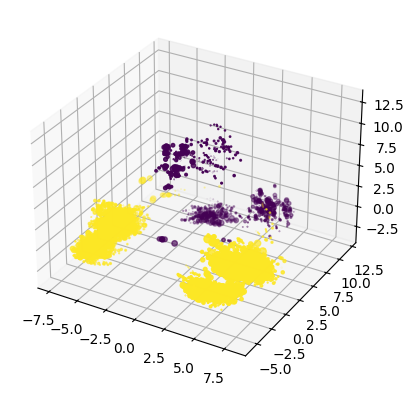

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
z = pca.fit_transform(preds)
plot(z, c=labels)

<Axes3D: >

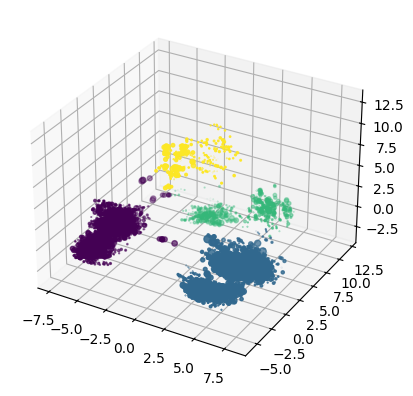

In [10]:
from sklearn.cluster import Birch

model = Birch(threshold=0.75, n_clusters=4)
clusters = model.fit_predict(z)
plot(z, c=clusters)


Accuracy on 0: 98.85%
Accuracy on 1: 99.64%
Accuracy: 99.55%


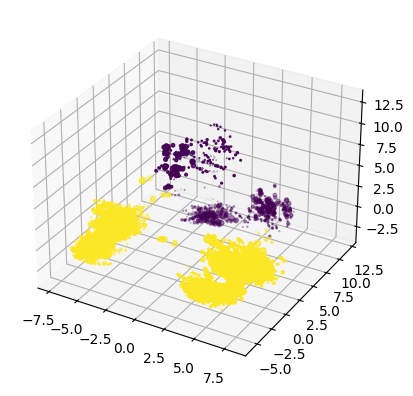

In [11]:
y_hat = (clusters == 0) + (clusters == 1)
plot(z, c=y_hat)

labels0 = labels[labels == 0]
y_hat0 = y_hat[labels == 0]
labels1 = labels[labels == 1]
y_hat1 = y_hat[labels == 1]

print(f"""
Accuracy on 0: {100 * (y_hat0 == labels0).sum() / len(labels0):.2f}%
Accuracy on 1: {100 * (y_hat1 == labels1).sum() / len(labels1):.2f}%
Accuracy: {100 * (y_hat == labels).sum() / len(labels):.2f}%
""")

In [14]:
labels[y_hat != labels]

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [20]:
np.argwhere(y_hat != labels).T

array([[  60,  379,  432,  817, 1136, 1189, 1574, 1867, 1893, 1946, 2331,
        2650, 2703, 3088, 3407, 3460, 3845, 4164, 4217, 4602, 4921, 4974,
        5359, 5652, 5678, 5731, 6116, 6409, 6435, 6488, 6873, 7166, 7192,
        7245]])

60


/Users/bhavyemathur/Desktop/Programming/Python/AIvolved/venv/lib/python3.11/site-packages/torchvision/tv_tensors/_tv_tensor.py:77: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3679.)
  output = func(*args, **kwargs or dict())


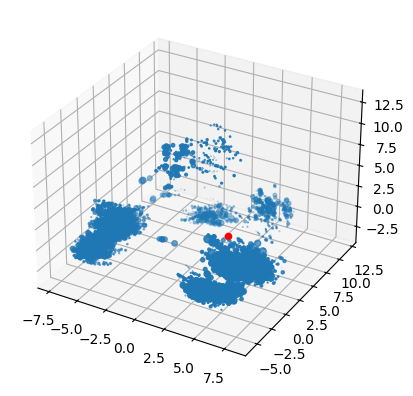

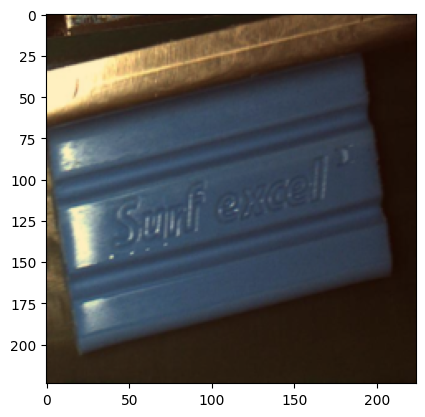

In [21]:
import random
i = random.randint(0, len(z))

# i = 36
# i = 109
# i = 80
i = 60
print(i)

img = train_dataset[i][0].T
img -= img.min()
img /= img.max()

ax = plot(z)
ax.scatter3D(*z[i][:2], s=20, c="red")

plt.figure()
plt.imshow(img)

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, stdev)
])

train_dataset = torchvision.datasets.ImageFolder(DATA_PATH + "train", transform=test_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=256, num_workers=8, pin_memory=True, persistent_workers=True)

import time

start = time.time()
for epoch in tqdm(range(10)):
    for x, y in train_dataloader:
        x = x.to(device)
        _ = resnet(x)
        
end = time.time()
print(len(train_dataset) * 10 / (end - start))